# Behavioural Cloning Project

## 1. Import Data from Folders

In [118]:
import csv
import os
from sklearn.model_selection import train_test_split

# Load data from file.
samples = os.listdir('data')
lines = []

# Loop through all directories.
for sample in samples:
    current_dir = './data/' + sample
    with open(current_dir + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            line[0] = current_dir + '/IMG/' + line[0].split('/')[-1]
            line[1] = current_dir + '/IMG/' + line[1].split('/')[-1]
            line[2] = current_dir + '/IMG/' + line[2].split('/')[-1]
            lines.append(line)

# Split data into training and validation set.
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

## 2. Populate Images and Measurements

In [124]:
import cv2
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

def generator(samples, batch_size=32):
    """Data Generator to Prevent Overflow
    
    Returns:
      List, images of left/right/center camera.
      List, steering angles.
    """
    steering_bias_left = 0.2
    steering_bias_right = -0.2
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                # Collect Images & Measurements.
                image_c = cv2.imread(batch_sample[0])
                image_l = cv2.imread(batch_sample[1])
                image_r = cv2.imread(batch_sample[2])
                measurement_c = float(batch_sample[3])
                measurement_l = float(measurement_c + steering_bias_left)
                measurement_r = float(measurement_c + steering_bias_right)

                # Add Normal & Mirrored Images.
                images.append(image_c)
                images.append(np.fliplr(image_c))
                images.append(image_l)
                images.append(np.fliplr(image_l))
                images.append(image_r)
                images.append(np.fliplr(image_r))

                # Add Normal & Mirrored Steering.
                measurements.append(measurement_c)
                measurements.append(-measurement_c)
                measurements.append(measurement_l)
                measurements.append(-measurement_l)
                measurements.append(measurement_r)
                measurements.append(-measurement_r)

            # Set data into array.
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

## 3. Model Architecture.

In [125]:
from keras.models import Sequential
from keras.layers import Activation, Cropping2D, Dense
from keras.layers import Dropout, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D

# NVIDIA Architecture.
model = Sequential()

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(0.50))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.50))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

## 4. Train the Model.

Epoch 1/10
23586/23586 [==============================] - 390s - loss: 0.0267 - val_loss: 0.0244
Epoch 2/10
23586/23586 [==============================] - 367s - loss: 0.0235 - val_loss: 0.0256
Epoch 3/10
23586/23586 [==============================] - 401s - loss: 0.0223 - val_loss: 0.0224
Epoch 4/10
23586/23586 [==============================] - 421s - loss: 0.0213 - val_loss: 0.0229
Epoch 5/10
23586/23586 [==============================] - 422s - loss: 0.0206 - val_loss: 0.0206
Epoch 6/10
23586/23586 [==============================] - 436s - loss: 0.0198 - val_loss: 0.0200
Epoch 7/10
23586/23586 [==============================] - 422s - loss: 0.0193 - val_loss: 0.0197
Epoch 8/10
23586/23586 [==============================] - 416s - loss: 0.0186 - val_loss: 0.0196
Epoch 9/10
23586/23586 [==============================] - 417s - loss: 0.0180 - val_loss: 0.0190
Epoch 10/10
23586/23586 [==============================] - 421s - loss: 0.0178 - val_loss: 0.0181


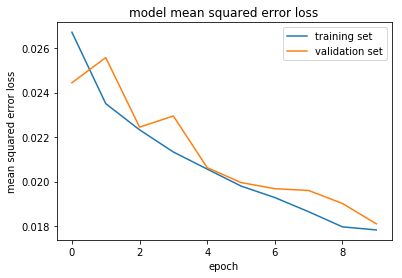

In [130]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples)*6,
                    nb_epoch=10)

# Save Training Model.
model.save('model_full_nvidia.h5')

# Visualize the Loss.
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()